In [87]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV 
from sklearn.preprocessing import PolynomialFeatures, scale, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from itertools import combinations
from tqdm import tqdm

## Question 8

### 8.a

In [88]:
np.random.seed(5)
# predictor X vector
x = np.random.randn(100, 1)
# noise vector
eps = np.random.randn(100, 1)

### 8.b

In [89]:
betas = [5, -10, 3, 14]

y = betas[0] + betas[1] * x + betas[2] * (x**2) + betas[3] * (x**3) + eps

### 8.c

In [90]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(x)

cols = ['x'+str(i) for i in range(1, 11)] + ['y']
X_df = pd.DataFrame(np.concatenate((X_poly,y), axis=1), columns=cols)
X_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.441227,0.194682,0.085899,0.037901,0.016723,0.007379,3.255652e-03,1.436483e-03,6.338158e-04,2.796569e-04,3.166778
1,-0.330870,0.109475,-0.036222,0.011985,-0.003965,0.001312,-4.341133e-04,1.436351e-04,-4.752458e-05,1.572447e-05,8.300783
2,2.430771,5.908649,14.362573,34.912128,84.863394,206.283494,5.014280e+02,1.218857e+03,2.962762e+03,7.201796e+03,197.740511
3,-0.252092,0.063550,-0.016021,0.004039,-0.001018,0.000257,-6.470160e-05,1.631076e-05,-4.111815e-06,1.036556e-06,8.117581
4,0.109610,0.012014,0.001317,0.000144,0.000016,0.000002,1.900846e-07,2.083514e-08,2.283736e-09,2.503200e-10,4.456710


In [91]:
def process_linear_model(subset, data, response):
    x_train = sm.add_constant(data[subset])
    model = sm.OLS(response, x_train).fit()
    train_RSS = model.ssr
    return (model, train_RSS)

def find_best_subset(data, response, max_features, operation):
    best_sub_list = []
    best_model = []
    num_of_features = []
    
    for k in tqdm(range(1, max_features+1)):
        best_rss = np.inf
        best_kth_model = None
        
        subsets = combinations(data.columns, k)
        
        for subset in subsets:
            result = process_linear_model(list(subset), data, response)
            if result[1] < best_rss:
                best_rss = result[1]
                best_subset = list(subset)
                best_kth_model = result[0]
                
        num_of_features.append(k)
        best_sub_list.append(best_subset)
        best_model.append(best_kth_model)
            
    results = pd.DataFrame({'sub': best_sub_list, 'model': best_model})
    results.to_pickle(f'../../data/{operation}.pkl')
    return results

In [92]:
X = X_df.drop(['y'], axis=1)
y = X_df.y

bestsub_results = find_best_subset(X, y, 10, 'poly_bestsub')

100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


In [93]:
# best subset selection results
bestsub_results

,sub,model
0,[x3],<statsmodels.regression.linear_model.Regressio...
1,"[x5, x7]",<statsmodels.regression.linear_model.Regressio...
2,"[x1, x2, x3]",<statsmodels.regression.linear_model.Regressio...
3,"[x1, x2, x3, x5]",<statsmodels.regression.linear_model.Regressio...
4,"[x1, x2, x3, x7, x10]",<statsmodels.regression.linear_model.Regressio...
5,"[x1, x2, x3, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
6,"[x1, x2, x3, x5, x6, x7, x9]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x2, x3, x5, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x1, x2, x3, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


In [94]:
aic = [bestsub_results.model[i].aic for i in range(0, len(bestsub_results.model))]
bic = [bestsub_results.model[i].bic for i in range(0, len(bestsub_results.model))]
r2_adj = [bestsub_results.model[i].rsquared_adj for i in range(0, len(bestsub_results.model))]
rss = [bestsub_results.model[i].ssr for i in range(0, len(bestsub_results.model))]

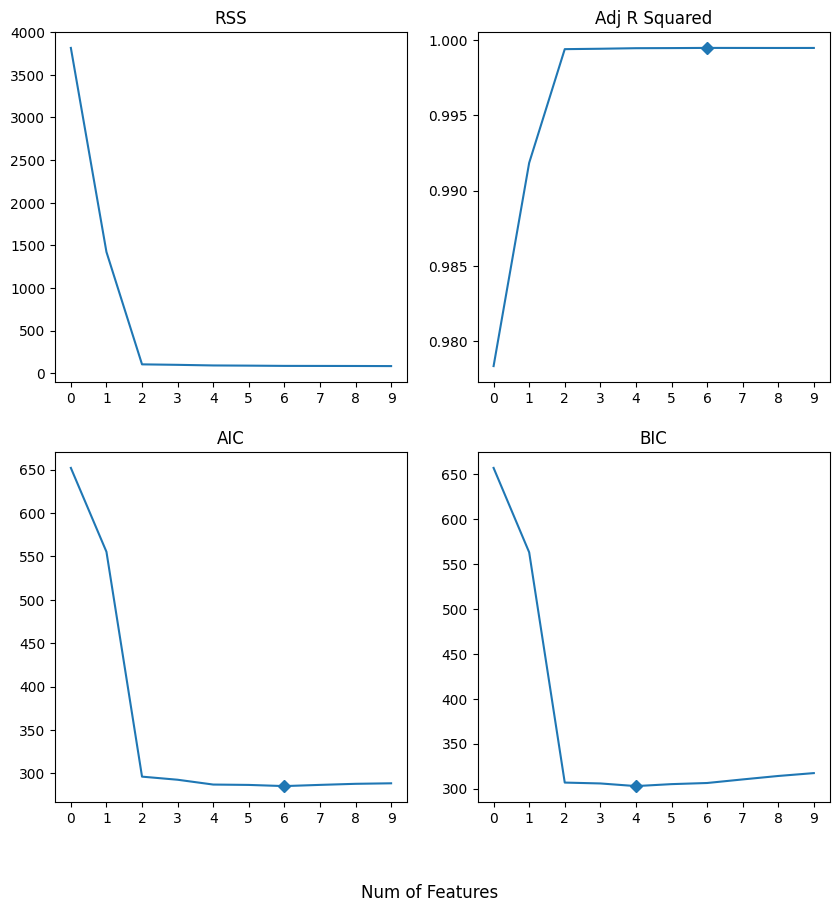

In [95]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj, markevery=[np.argmax(r2_adj)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic, markevery=[np.argmin(aic)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic, markevery=[np.argmin(bic)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

#### The best model obtained:
According to
- BIC => 5-variable model [x1, x2, x3, x7, x10]	
- Adjusted R2 & AIC => 7-variable model [x1, x2, x3, x5, x6, x7, x9]

In [96]:
# Coefficient estimates for best model obtained acc.to BIC
bestsub_results.model[4].params

const     4.947337
x1      -10.429378
x2        3.073473
x3       14.450429
x7       -0.011511
x10      -0.000260
dtype: float64

In [97]:
# Coefficient estimates for best model obtained acc.to AIC and Adjusted R2
bestsub_results.model[6].params

const     5.068818
x1       -9.646528
x2        2.789910
x3       12.042326
x5        1.870729
x6        0.033739
x7       -0.504306
x9        0.038531
dtype: float64

### 8.d

In [98]:
def forward_stepwise(X, y, max_features):
    models = []
    feature_list = []
    remaining_features = list(X.columns)
    
    def update_model(current_features, remaining_features):
        best_rss = np.inf
        best_model = None
        
        for new_feature in tqdm(remaining_features):
            result = process_linear_model(feature_list + [new_feature], X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                best_model = result[0]

        new_feature_list = list(best_model.params.index)[1:]
        
        return new_feature_list, best_model
    
    while remaining_features and len(feature_list) < max_features:
        feature_list, best_model = update_model(feature_list, remaining_features)
        remaining_features = [x for x in list(X.columns) if x not in feature_list]
        models.append([feature_list, best_model])
        
    return models

In [99]:
bestsub_forward = forward_stepwise(X, y, 10)

100%|██████████| 1/1 [00:00<00:00, 663.66it/s]


In [100]:
aic_fwd = [model[1].aic for model in bestsub_forward]
bic_fwd = [model[1].bic for model in bestsub_forward] 
r2_adj_fwd = [model[1].rsquared_adj for model in bestsub_forward]
rss_fwd = [model[1].ssr for model in bestsub_forward]

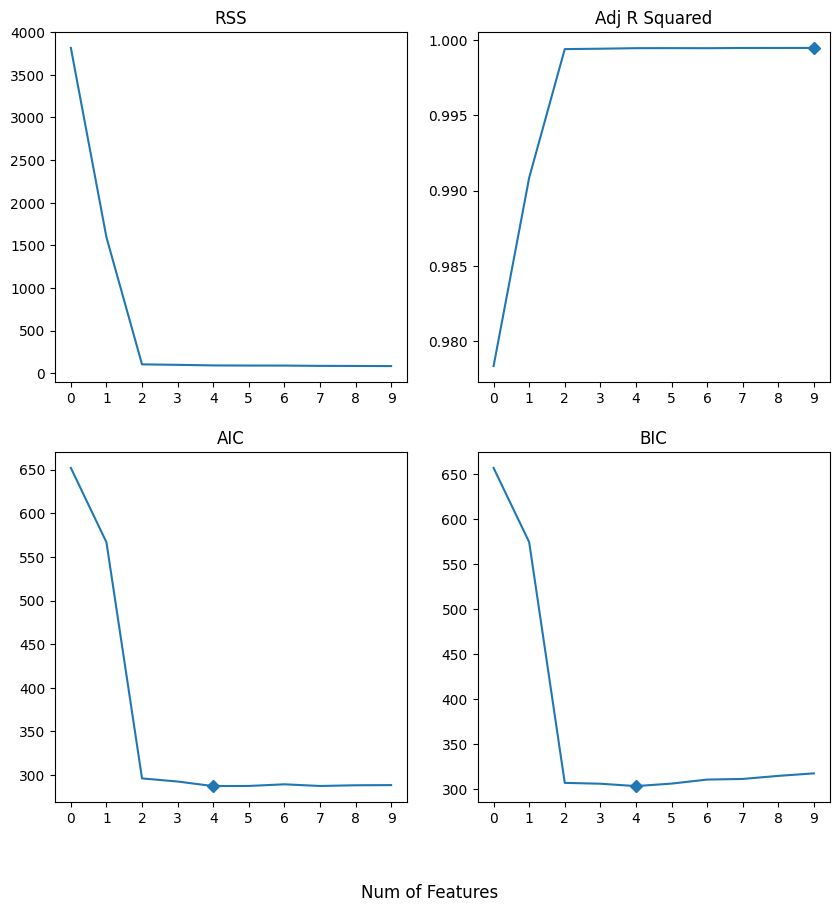

In [101]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss_fwd)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj_fwd, markevery=[np.argmax(r2_adj_fwd)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic_fwd, markevery=[np.argmin(aic_fwd)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic_fwd, markevery=[np.argmin(bic_fwd)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))
plt.show()

In [102]:
print('4-variable model parameter acc.t. forward stepwise: ', bestsub_forward[4][0])
print('9-variable model parameter acc.t. forward stepwise: ', bestsub_forward[9][0])

4-variable model parameter acc.t. forward stepwise:  ['x3', 'x1', 'x2', 'x5', 'x10']
9-variable model parameter acc.t. forward stepwise:  ['x3', 'x1', 'x2', 'x5', 'x10', 'x4', 'x7', 'x9', 'x8', 'x6']


#### The best model obtained:
According to
- BIC & AIC => 5-variable model ['x3', 'x1', 'x2', 'x5', 'x10']
- Adjusted R2 => 10-variable model ['x3', 'x1', 'x2', 'x5', 'x10', 'x4', 'x7', 'x9', 'x8', 'x6']

In [103]:
def backward_stepwise(X, y, min_feature):
    models = []
    feature_list = list(X.columns)
    
    def update_model(feature_list):
        best_rss = np.inf
        best_model = None
        best_feature_list = []
        
        for feature in tqdm(feature_list):
            new_feature_list = [x for x in feature_list if x != feature]
            
            result = process_linear_model(new_feature_list, X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                best_model = result[0]
        
        best_feature_list = list(best_model.params.index)[1:]
        return best_feature_list, best_model
    
    while len(feature_list) >= min_feature:
        best_feature_list, best_model = update_model(feature_list)
        feature_list = best_feature_list
        models.append([feature_list, best_model])
    
    return models

In [104]:
bestsub_backward = backward_stepwise(X, y, 1)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [105]:
aic_back = [model[1].aic for model in bestsub_backward]
bic_back = [model[1].bic for model in bestsub_backward] 
r2_adj_back = [model[1].rsquared_adj for model in bestsub_backward]
rss_back = [model[1].ssr for model in bestsub_backward]

#### The best model obtained:
According to
- BIC & AIC => 5-variable model ['x3', 'x1', 'x2', 'x5', 'x10']
- Adjusted R2 => 10-variable model ['x3', 'x1', 'x2', 'x5', 'x10', 'x4', 'x7', 'x9', 'x8', 'x6']

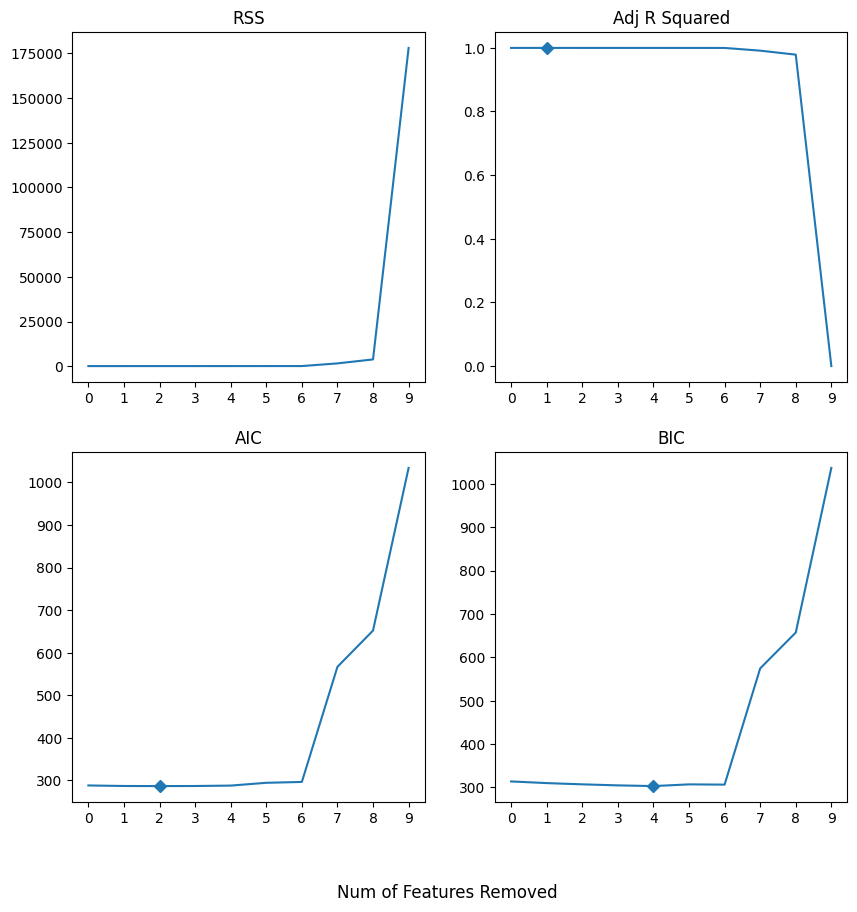

In [106]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features Removed')

axes[0, 0].plot(rss_back)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj_back, markevery=[np.argmax(r2_adj_back)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic_back, markevery=[np.argmin(aic_back)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic_back, markevery=[np.argmin(bic_back)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))
plt.show()

In [107]:
print('8-variable model parameter acc.t. backward stepwise: ', bestsub_backward[1][0])
print('7-variable model parameter acc.t. backward stepwise: ', bestsub_backward[2][0])
print('5-variable model parameter acc.t. backward stepwise: ', bestsub_backward[4][0])

8-variable model parameter acc.t. backward stepwise:  ['x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9', 'x10']
7-variable model parameter acc.t. backward stepwise:  ['x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9']
5-variable model parameter acc.t. backward stepwise:  ['x1', 'x2', 'x3', 'x7', 'x9']


#### The best model obtained:
According to
- BIC => 5-variable model ['x1', 'x2', 'x3', 'x7', 'x9']
- Adjusted R2 => 8-variable model ['x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9', 'x10']
- AIC => 7-variable model ['x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9']

#### As shown above, we can say that subset selection results may differ depending on the algorithm used

### 8.e

In [108]:
alphas = np.logspace(-4, -1, 100)
lassocv = LassoCV(alphas=alphas, cv=5, max_iter=100000)

lassocv.fit(scale(X), y)

LassoCV(alphas=array([0.0001    , 0.00010723, 0.00011498, 0.00012328, 0.00013219,
       0.00014175, 0.00015199, 0.00016298, 0.00017475, 0.00018738,
       0.00020092, 0.00021544, 0.00023101, 0.00024771, 0.00026561,
       0.0002848 , 0.00030539, 0.00032745, 0.00035112, 0.00037649,
       0.0004037 , 0.00043288, 0.00046416, 0.0004977 , 0.00053367,
       0.00057224, 0.00061359, 0.00065793, 0.00070548, 0.00075646,
       0.000...
       0.00932603, 0.01      , 0.01072267, 0.01149757, 0.01232847,
       0.01321941, 0.01417474, 0.01519911, 0.01629751, 0.01747528,
       0.01873817, 0.02009233, 0.02154435, 0.0231013 , 0.02477076,
       0.02656088, 0.02848036, 0.03053856, 0.03274549, 0.03511192,
       0.03764936, 0.04037017, 0.04328761, 0.04641589, 0.04977024,
       0.05336699, 0.05722368, 0.06135907, 0.06579332, 0.07054802,
       0.07564633, 0.08111308, 0.0869749 , 0.09326033, 0.1       ]),
        cv=5, max_iter=100000)

In [109]:
# optimal value of alpha
lassocv.alpha_

0.061359072734131756

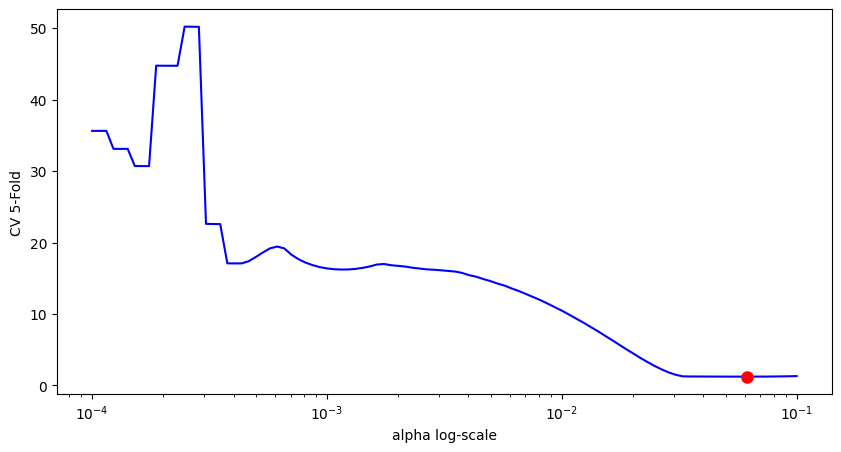

In [110]:
mses = np.mean(lassocv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lassocv.alphas_,mses, color='b');
ax.plot(lassocv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [111]:
pd.Series(lassocv.coef_.flatten(), index=X.columns)

x1     -8.818816
x2      3.878525
x3     48.509026
x4      0.000000
x5      0.000000
x6     -0.000000
x7      0.000000
x8     -0.000000
x9      0.000000
x10    -0.000000
dtype: float64

### 8.f

In [112]:
y2 = -4 + 7.25 * (x**7) + eps

### 8.f - Best subset selection


In [113]:
bestsub2 = find_best_subset(X, y2, 10, 'poly_bestsub_2')
bestsub2

100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


,sub,model
0,[x7],<statsmodels.regression.linear_model.Regressio...
1,"[x3, x7]",<statsmodels.regression.linear_model.Regressio...
2,"[x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
3,"[x3, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
4,"[x3, x5, x6, x7, x9]",<statsmodels.regression.linear_model.Regressio...
5,"[x2, x3, x4, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
6,"[x3, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x3, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


In [114]:
aic2 = [bestsub2.model[i].aic for i in range(0, len(bestsub2.model))]
bic2 = [bestsub2.model[i].bic for i in range(0, len(bestsub2.model))]
r2_adj2 = [bestsub2.model[i].rsquared_adj for i in range(0, len(bestsub2.model))]
rss2 = [bestsub2.model[i].ssr for i in range(0, len(bestsub2.model))]

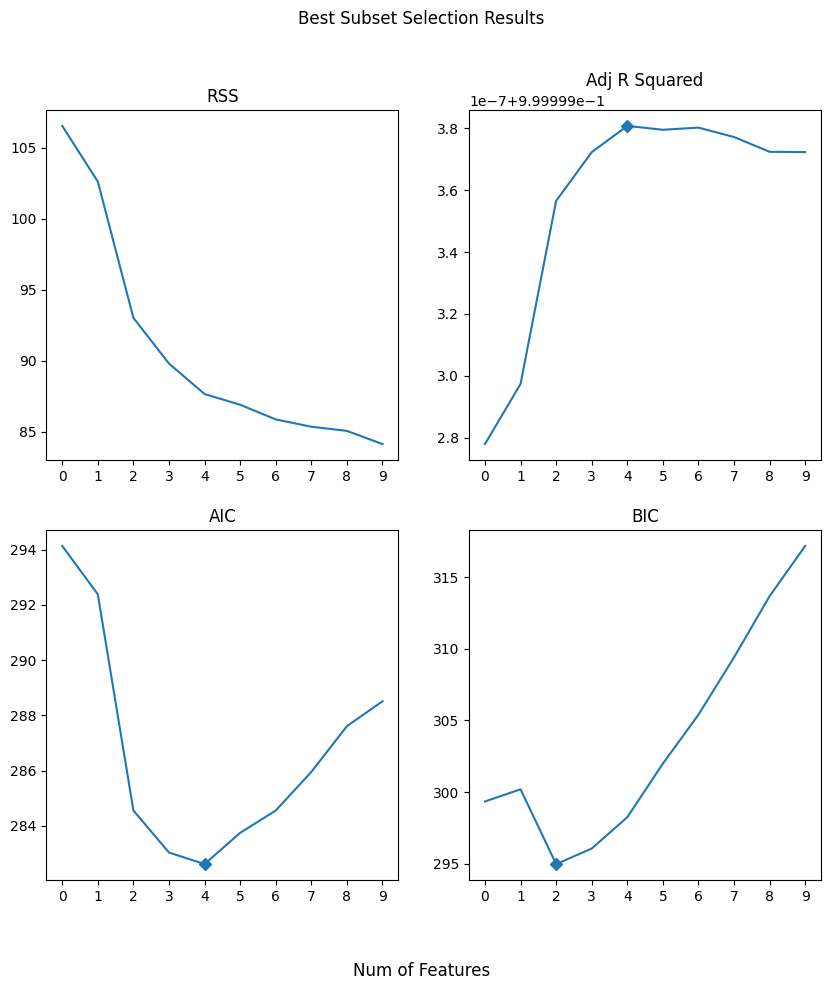

In [115]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

fig.suptitle('Best Subset Selection Results')

axes[0, 0].plot(rss2)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj2, markevery=[np.argmax(r2_adj2)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic2, markevery=[np.argmin(aic2)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic2, markevery=[np.argmin(bic2)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

plt.show()

In [116]:
np.random.seed(5)
lassocv2 = LassoCV(n_alphas=400, cv=10, max_iter=10000)

lassocv2.fit(scale(X), y2.ravel())

LassoCV(cv=10, max_iter=10000, n_alphas=400)

In [117]:
# optimal value of alpha
lassocv2.alpha_

1.2210192922875795

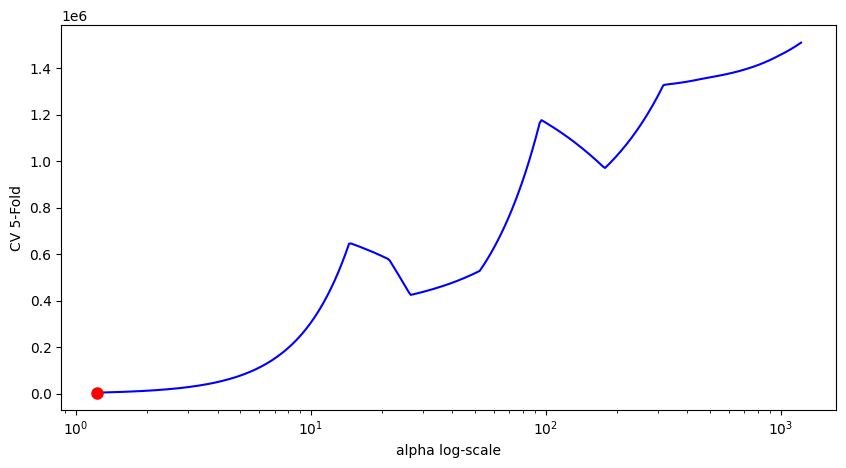

In [118]:
mses = np.mean(lassocv2.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lassocv2.alphas_,mses, color='b');
ax.plot(lassocv2.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [119]:
# Coefficient estimates of lasso model
pd.Series(lassocv2.coef_.flatten(), index=X.columns)

x1       -0.000000
x2        0.000000
x3        0.000000
x4        0.000000
x5       59.222959
x6        0.000000
x7     1069.219682
x8       -0.000000
x9       93.073638
x10      -0.000000
dtype: float64

#### As we can observe from the coefficient estimates, the lasso model includes only two noise variables (x5, x7), whereas the best-subset selection model contains more noise variables. Hence, it is evident that the lasso outperforms the best-subset selection in terms of noise reduction and feature selection.

## Question 9

### 9.a

In [120]:
college = pd.read_csv('../../data/college.csv', index_col=0).dropna()
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [121]:
college['Private'] = pd.get_dummies(college['Private']).iloc[:, 0]

In [122]:
college.isna().any()

Private        False
Apps           False
Accept         False
Enroll         False
Top10perc      False
Top25perc      False
F.Undergrad    False
P.Undergrad    False
Outstate       False
Room.Board     False
Books          False
Personal       False
PhD            False
Terminal       False
S.F.Ratio      False
perc.alumni    False
Expend         False
Grad.Rate      False
dtype: bool

In [123]:
X_train, X_test, y_train, y_test = train_test_split(college.drop(['Apps'], axis=1), college.Apps, test_size=0.5, random_state=1)

### 9.b

In [124]:
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)
mean_squared_error(y_test, lr.predict(X_test))

1425055.5873112378

Text(0.5, 1.0, 'Residual Plot')

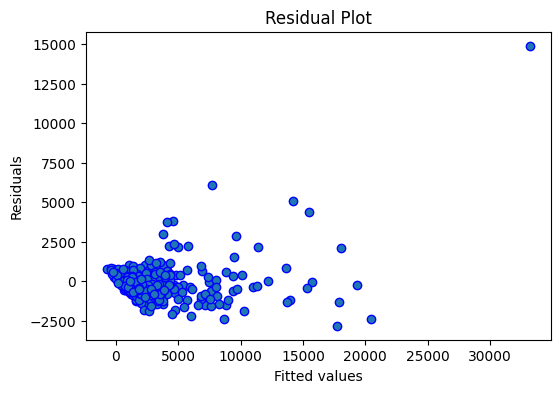

In [125]:
fitted_values = lr.predict(X_test)
residuals = y_test - fitted_values

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fitted_values, residuals, edgecolors='b');
ax.set_xlabel('Fitted values');
ax.set_ylabel('Residuals');
ax.set_title('Residual Plot')

#### From the plot above, it is evident that the residual plot has a pattern, which may indicate that the relationship between the response and the predictors is nonlinear.

### 9.c

In [126]:
alphas = np.logspace(-4, 0, 100)

ridgecv = RidgeCV(alphas=alphas, store_cv_values=True)
ridgecv.fit(X_train, y_train)

print(f'Optimal value of alpha chosen by cross-valiation: {ridgecv.alpha_}')

Optimal value of alpha chosen by cross-valiation: 1.0


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [127]:
# Min mse value obtained by cross-validation
mses = np.mean(ridgecv.cv_results_, axis=0)
min_mse = np.min(mses)
min_mse

1291210.544319996

In [128]:
pd.Series(ridgecv.coef_.flatten(), index=X_train.columns)

Private        435.222306
Accept           1.142032
Enroll           0.487520
Top10perc       62.793075
Top25perc      -22.722444
F.Undergrad     -0.005925
P.Undergrad      0.016668
Outstate        -0.067387
Room.Board       0.247228
Books           -0.207027
Personal        -0.085628
PhD             -6.257675
Terminal        -3.601403
S.F.Ratio        7.825445
perc.alumni    -10.548037
Expend           0.057815
Grad.Rate       12.040150
dtype: float64

### 9.d

In [129]:
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=1000)
lassocv.fit(X_train, y_train)

print(f'Optimal value of alpha chosen by cross-valiation: {lassocv.alpha_}')

Optimal value of alpha chosen by cross-valiation: 1.0


In [130]:
mses = np.mean(lassocv.mse_path_, axis=1)
min_mse = np.min(mses)
min_mse

1284070.9604433784

In [131]:
pd.Series(lassocv.coef_.flatten(), index=X_train.columns)

Private        437.153494
Accept           1.142031
Enroll           0.487827
Top10perc       62.755204
Top25perc      -22.697526
F.Undergrad     -0.006027
P.Undergrad      0.016660
Outstate        -0.067307
Room.Board       0.247246
Books           -0.206702
Personal        -0.085643
PhD             -6.257268
Terminal        -3.609594
S.F.Ratio        7.686707
perc.alumni    -10.528380
Expend           0.057793
Grad.Rate       12.031905
dtype: float64

### 9.e

In [132]:
scores = []

# Compute the CV Score for no principal components, Linear Reg. only with intercept
scores.append(-np.mean(cross_val_score(LinearRegression(), np.ones((X_train.shape[0], 1)),
                                     y_train, cv=5, scoring='neg_mean_squared_error')))

for i in np.arange(1, X_train.shape[1]+1):
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_train)
    
    pca = PCA(n_components=i)
    X_pcr = pca.fit_transform(X_)
    
    score = -np.mean(cross_val_score(LinearRegression(), X_pcr[:, :i],
                                    y_train, cv=5, scoring='neg_mean_squared_error'))
    
    scores.append(score)

In [133]:
print(np.argmin(scores), np.min(scores))

16 1312200.0054480806


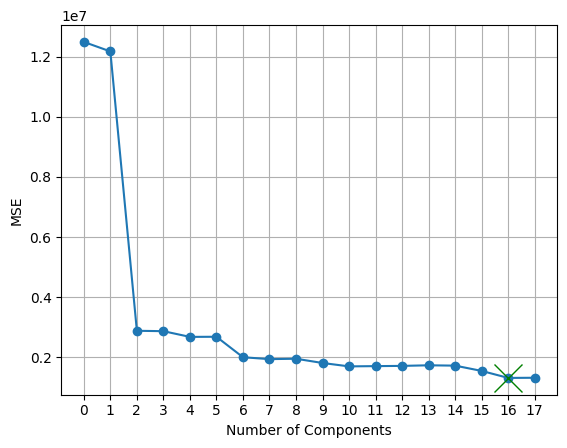

In [134]:
plt.plot(scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.xticks(np.arange(0, X_train.shape[1]+1, 1))

plt.plot(np.argmin(scores), np.min(scores), 'gx', markersize=20)
plt.grid()

`M=16` is the optimal number of components chosen by cross-validation

### 9.f

In [135]:
scores_pls = []

for i in np.arange(1, X_train.shape[1]+1):
    score = -np.mean(cross_val_score(PLSRegression(n_components=i),
                                    scale(X_train), y_train,
                                    cv=5, scoring='neg_mean_squared_error'))
    
    scores_pls.append(score)

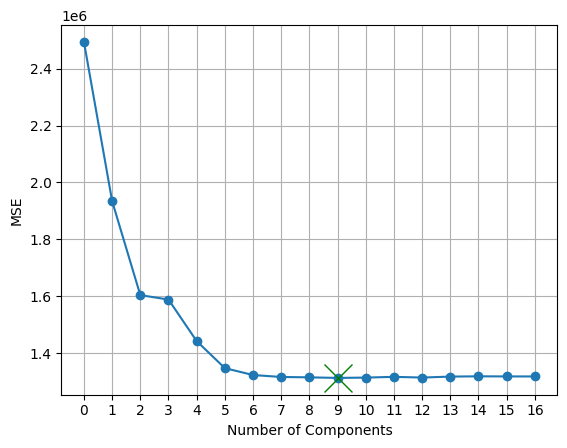

In [136]:
plt.plot(scores_pls, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.xticks(np.arange(0, X_train.shape[1], 1))

plt.plot(np.argmin(scores_pls), np.min(scores_pls), 'gx', markersize=20)
plt.grid()

`M=10` is the optimal number of components chosen by cross-validation

In [137]:
np.argmin(scores_pls), np.min(scores_pls)

(9, 1312383.0038373969)

### 9.g

Test error results obtained from different approaches:
- Least Squares Method: 1425055.5873112478
- Ridge Regression: 1291210.5443199938
- Lasso: 1284070.9604433614
- Principal Component Regression: 1312200.005448079
- Partial Least Squares: 1312383.003837396

As we can see from the results above, each method has a similar error rate on the test set. However, the worst-performing model is the least squares method, and the best-performing one is the Lasso. It's important to note that these results may vary depending on the seed used for dataset splitting.

## Question 10

### 10.a

In [138]:
np.random.seed(42)

# Generate random data
X = np.random.normal(size=(1000, 20))
betas = np.random.randint(-10, 20, 20)

betas[19] = 0
betas[4] = 0
betas[12] = 0
betas[7] = 0
betas[10] = 0
betas[14] = 0

eps = 10**np.random.randn(1000)

y = np.dot(X, betas) + eps

# Create DataFrame
data = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(1, 21)])
data['Target'] = y

data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Target
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,-24.688306
1,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,...,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,11.230263
2,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,...,-0.385082,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,6.614350
3,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,...,1.538037,-0.035826,1.564644,-2.619745,0.821903,0.087047,-0.299007,0.091761,-1.987569,14.355512
4,-0.219672,0.357113,1.477894,-0.518270,-0.808494,-0.501757,0.915402,0.328751,-0.529760,0.513267,...,0.968645,-0.702053,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,34.428013


### 10.b

In [139]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Target'], axis=1), data.Target, test_size=0.9, random_state=1)

### 10.c

In [ ]:
bestsub_result = find_best_subset(X_train, y_train, 20, 'feature_mse_test')

 40%|████      | 8/20 [08:09<25:14, 126.25s/it]

In [ ]:
bestsub_results = pd.read_pickle('../../data/feature_mse_test.pkl')
bestsub_results

,sub,model
0,[Feature_17],<statsmodels.regression.linear_model.Regressio...
1,"[Feature_17, Feature_18]",<statsmodels.regression.linear_model.Regressio...
2,"[Feature_3, Feature_17, Feature_18]",<statsmodels.regression.linear_model.Regressio...
3,"[Feature_3, Feature_12, Feature_17, Feature_18]",<statsmodels.regression.linear_model.Regressio...
4,"[Feature_3, Feature_12, Feature_16, Feature_17...",<statsmodels.regression.linear_model.Regressio...
5,"[Feature_1, Feature_3, Feature_12, Feature_16,...",<statsmodels.regression.linear_model.Regressio...
6,"[Feature_1, Feature_2, Feature_3, Feature_12, ...",<statsmodels.regression.linear_model.Regressio...
7,"[Feature_1, Feature_2, Feature_3, Feature_6, F...",<statsmodels.regression.linear_model.Regressio...
8,"[Feature_1, Feature_2, Feature_3, Feature_6, F...",<statsmodels.regression.linear_model.Regressio...
9,"[Feature_1, Feature_2, Feature_3, Feature_6, F...",<statsmodels.regression.linear_model.Regressio...


In [ ]:
training_MSEs = []
for idx, row in bestsub_results.iterrows():
    model = row.iloc[1]  # Use iloc for positional indexing
    pred = model.predict(sm.add_constant(X_train[row.iloc[0]]))  # Use iloc for positional indexing
    mse = mean_squared_error(y_train, pred)
    training_MSEs.append(mse)

C:\Users\admin\AppData\Local\Temp\ipykernel_10384\440207555.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\440207555.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.predict(sm.add_constant(X_train[row[0]]))
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\440207555.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admin\

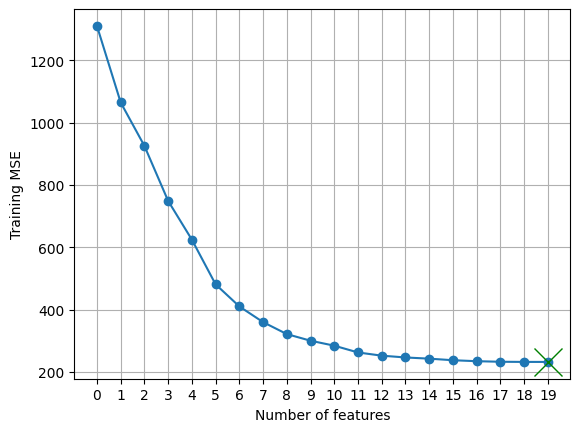

In [ ]:
plt.plot(training_MSEs, marker='o')
plt.xlabel('Number of features')
plt.ylabel('Training MSE')
plt.xticks(np.arange(0, X_train.shape[1], 1))

plt.plot(np.argmin(training_MSEs), np.min(training_MSEs), 'gx', markersize=20)
plt.grid()

### 10.d

In [ ]:
test_MSEs = []
for idx, row in bestsub_results.iterrows():
    model = row.iloc[1]
    pred = model.predict(sm.add_constant(X_test[row.iloc[0]]))
    mse = mean_squared_error(y_test, pred)
    test_MSEs.append(mse)    

C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1523619692.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1523619692.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.predict(sm.add_constant(X_test[row[0]]))
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1523619692.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admi

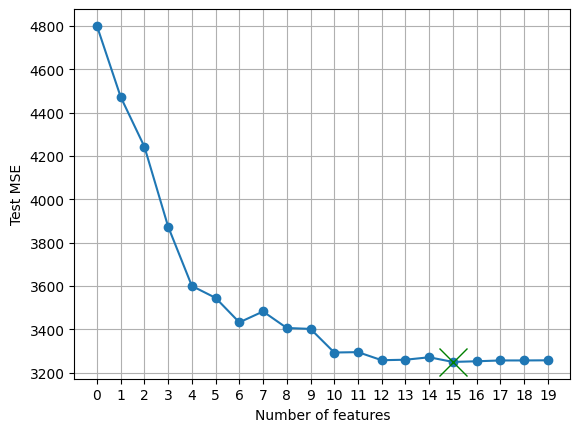

In [ ]:
plt.plot(test_MSEs, marker='o')
plt.xlabel('Number of features')
plt.ylabel('Test MSE')
plt.xticks(np.arange(0, X_train.shape[1], 1))

plt.plot(np.argmin(test_MSEs), np.min(test_MSEs), 'gx', markersize=20)
plt.grid()

### 10.e

Based on the results obtained, it is clear that the test MSE reaches its minimum value when `M=16`. When only considering the training MSE values, it is expected that the resulting model would contain all the features. However, when examining the test MSE values of the best subset selection results, it is important to note that training MSE is not a reliable estimator of test MSE. Thus, the best subset selection algorithm has identified a model containing only 16 features that achieves the lowest test MSE.


### 10.f

In [ ]:
# Coefficient Estimates
bestsub_results.model[15].params

const          5.008684
Feature_1      8.436100
Feature_2      8.420018
Feature_3      9.989320
Feature_4     -6.039841
Feature_6     -6.820919
Feature_7     -6.832604
Feature_8      2.307929
Feature_9      4.835346
Feature_10     3.043207
Feature_11    -2.704348
Feature_12    18.236244
Feature_14    -3.687013
Feature_16    14.593599
Feature_17    11.685969
Feature_18    18.943363
Feature_19     4.521553
dtype: float64

In [ ]:
# Actual Parameters
pd.Series(betas, index=X_train.columns)

Feature_1      6
Feature_2      7
Feature_3     14
Feature_4     -7
Feature_5      0
Feature_6     -3
Feature_7     -7
Feature_8      0
Feature_9      4
Feature_10     2
Feature_11     0
Feature_12    19
Feature_13     0
Feature_14    -6
Feature_15     0
Feature_16    16
Feature_17    11
Feature_18    17
Feature_19     2
Feature_20     0
dtype: int32

### 10.g

In [ ]:
# TODO

## Question 11
### 11.a

In [ ]:
boston = pd.read_csv('../../data/boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [ ]:
X = boston.drop(['crim'], axis=1)
y = boston.crim

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

### 11.a Best subset selection

In [ ]:
bestsub_boston = find_best_subset(X_train, y_train, 12, 'boston_bestsub')
bestsub_boston

100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


,sub,model
0,[rad],<statsmodels.regression.linear_model.Regressio...
1,"[rad, lstat]",<statsmodels.regression.linear_model.Regressio...
2,"[zn, rad, lstat]",<statsmodels.regression.linear_model.Regressio...
3,"[zn, dis, rad, medv]",<statsmodels.regression.linear_model.Regressio...
4,"[zn, dis, rad, tax, medv]",<statsmodels.regression.linear_model.Regressio...
5,"[zn, indus, dis, rad, lstat, medv]",<statsmodels.regression.linear_model.Regressio...
6,"[zn, nox, dis, rad, ptratio, lstat, medv]",<statsmodels.regression.linear_model.Regressio...
7,"[zn, nox, dis, rad, tax, ptratio, lstat, medv]",<statsmodels.regression.linear_model.Regressio...
8,"[zn, indus, nox, dis, rad, tax, ptratio, lstat...",<statsmodels.regression.linear_model.Regressio...
9,"[zn, indus, chas, nox, dis, rad, tax, ptratio,...",<statsmodels.regression.linear_model.Regressio...


In [ ]:
test_MSEs = []
for idx, row in bestsub_boston.iterrows():
    model = row.iloc[1]
    pred = model.predict(sm.add_constant(X_test[row.iloc[0]]))
    mse = mean_squared_error(y_test, pred)
    test_MSEs.append(mse)

C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1301422458.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1301422458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.predict(sm.add_constant(X_test[row[0]]))
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1301422458.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admi

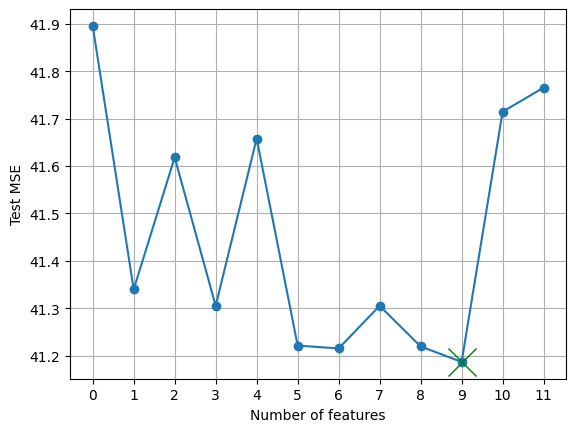

In [ ]:
plt.plot(test_MSEs, marker='o')
plt.xlabel('Number of features')
plt.ylabel('Test MSE')
plt.xticks(np.arange(0, X_train.shape[1], 1))

plt.plot(np.argmin(test_MSEs), np.min(test_MSEs), 'gx', markersize=20)
plt.grid()

In [ ]:
test_MSEs[9]

41.18668634182557

### 11.a Ridge

In [ ]:
alphas = np.logspace(-4, 0, 100)

ridgecv = RidgeCV(alphas=alphas, store_cv_results=True)
ridgecv.fit(X_train, y_train)

print(f'Optimal value of alpha chosen by cross-valiation: {ridgecv.alpha_}')

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal value of alpha chosen by cross-valiation: 0.394420605943766


In [ ]:
# Min mse value obtained by cross-validation
mses = np.mean(ridgecv.cv_results_, axis=0)
min_mse = np.min(mses)
min_mse

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


43.94836307966232

In [ ]:
pd.Series(ridgecv.coef_.flatten(), index=X_train.columns)

zn         0.070272
indus     -0.091545
chas      -0.975765
nox       -8.316559
rm        -0.481367
age        0.003328
dis       -1.051566
rad        0.682143
tax       -0.006095
ptratio   -0.289192
lstat      0.137294
medv      -0.214960
dtype: float64

### 11.a Lasso

In [ ]:
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=1000)
lassocv.fit(X_train, y_train)

print(f'Optimal value of alpha chosen by cross-valiation: {lassocv.alpha_}')

Optimal value of alpha chosen by cross-valiation: 0.0031257158496882354


In [ ]:
mses = np.mean(lassocv.mse_path_, axis=1)
min_mse = np.min(mses)
min_mse

44.11314039601287

In [ ]:
pd.Series(lassocv.coef_.flatten(), index=X_train.columns)

zn          0.070196
indus      -0.079694
chas       -0.897716
nox       -10.717986
rm         -0.474755
age         0.005179
dis        -1.090210
rad         0.687750
tax        -0.005932
ptratio    -0.325450
lstat       0.136968
medv       -0.221775
dtype: float64

### 11.a PCR

In [ ]:
scores = []

# Compute the CV Score for no principal components, Linear Reg. only with intercept
scores.append(-np.mean(cross_val_score(LinearRegression(), np.ones((X.shape[0], 1)),
                                     y, cv=5, scoring='neg_mean_squared_error')))

for i in np.arange(1, X.shape[1]+1):
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X)
    
    pca = PCA(n_components=i)
    X_pcr = pca.fit_transform(X_)
    
    score = -np.mean(cross_val_score(LinearRegression(), X_pcr[:, :i],
                                    y, cv=5, scoring='neg_mean_squared_error'))
    
    scores.append(score)

In [ ]:
print(np.argmin(scores), '-', np.min(scores))

7 - 45.978192718366515


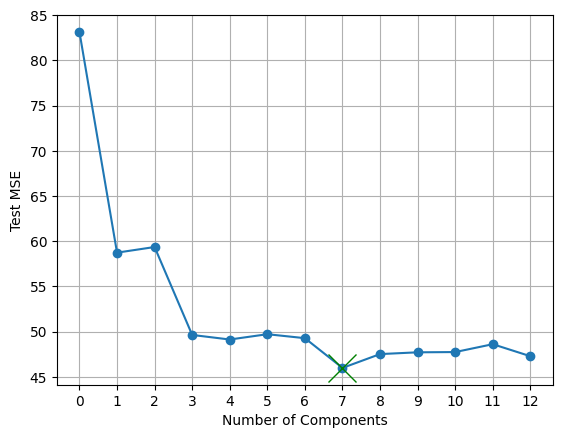

In [ ]:
plt.plot(scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Test MSE')
plt.xticks(np.arange(0, X_train.shape[1]+1, 1))

plt.plot(np.argmin(scores), np.min(scores), 'gx', markersize=20)
plt.grid()

### 11.b

#### Despite each method producing similar test errors, the best subset selection method yields the best result in this scenario. But since this option is computationally expensive than others, we can try to use a non-linear model for the `Boston` dataset.

Text(0, 0.5, 'Residuals')

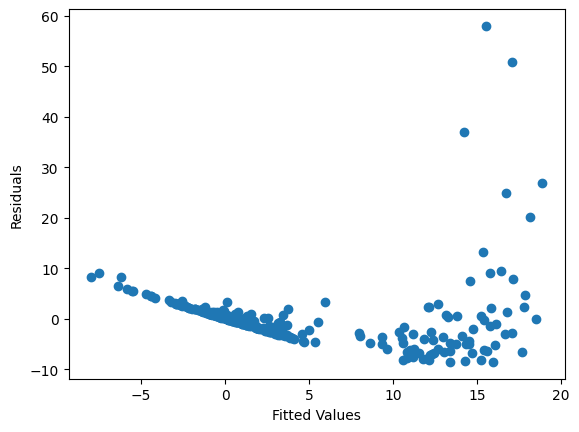

In [ ]:
lm_boston = LinearRegression(fit_intercept=True)
lm_boston.fit(X_train, y_train)

# residuals
resids = y_train - lm_boston.predict(X_train)
fitted_values = lm_boston.predict(X_train)

plt.scatter(fitted_values, resids, marker='o')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

It appears from the scatter plot that there is some non-linearity in the relationship between the response variable and the predictors, which is reflected in the pattern of the residuals. The residuals are not randomly scattered around the horizontal line at zero, but instead follow a curved pattern. This suggests that a linear regression model may not be the best fit for the data, and a more flexible model such as polynomial regression or a generalized additive model may be more appropriate.

<Axes: xlabel='medv', ylabel='crim'>

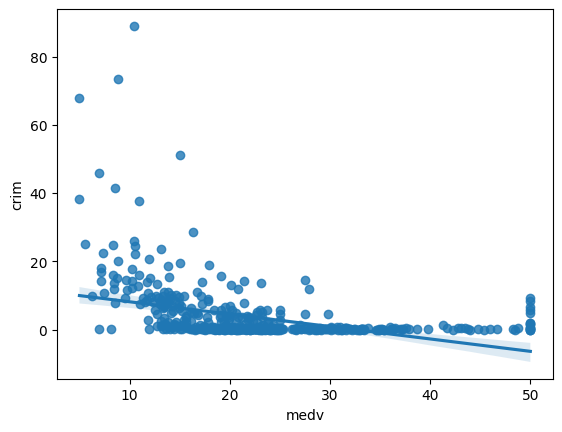

In [ ]:
# We can add quadratic and cubic terms of medv
sns.regplot(x='medv', y='crim', data=boston)

In [ ]:
X['medv2'] = np.power(X['medv'], 2)
X['medv3'] = np.power(X['medv'], 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
bestsub_boston2 = find_best_subset(X_train, y_train, 14, 'boston_bestsub2')
bestsub_boston2

100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


,sub,model
0,[rad],<statsmodels.regression.linear_model.Regressio...
1,"[rad, lstat]",<statsmodels.regression.linear_model.Regressio...
2,"[rad, medv, medv2]",<statsmodels.regression.linear_model.Regressio...
3,"[rad, medv, medv2, medv3]",<statsmodels.regression.linear_model.Regressio...
4,"[rm, rad, medv, medv2, medv3]",<statsmodels.regression.linear_model.Regressio...
5,"[rm, rad, lstat, medv, medv2, medv3]",<statsmodels.regression.linear_model.Regressio...
6,"[rm, rad, tax, lstat, medv, medv2, medv3]",<statsmodels.regression.linear_model.Regressio...
7,"[nox, rm, age, rad, lstat, medv, medv2, medv3]",<statsmodels.regression.linear_model.Regressio...
8,"[nox, rm, age, rad, ptratio, lstat, medv, medv...",<statsmodels.regression.linear_model.Regressio...
9,"[nox, rm, age, dis, rad, ptratio, lstat, medv,...",<statsmodels.regression.linear_model.Regressio...


In [ ]:
test_MSEs = []
for idx, row in bestsub_boston2.iterrows():
    model = row.iloc[1]
    pred = model.predict(sm.add_constant(X_test[row.iloc[0]]))
    mse = mean_squared_error(y_test, pred)
    test_MSEs.append(mse)

C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1363971802.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1363971802.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.predict(sm.add_constant(X_test[row[0]]))
C:\Users\admin\AppData\Local\Temp\ipykernel_10384\1363971802.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[1]
C:\Users\admi

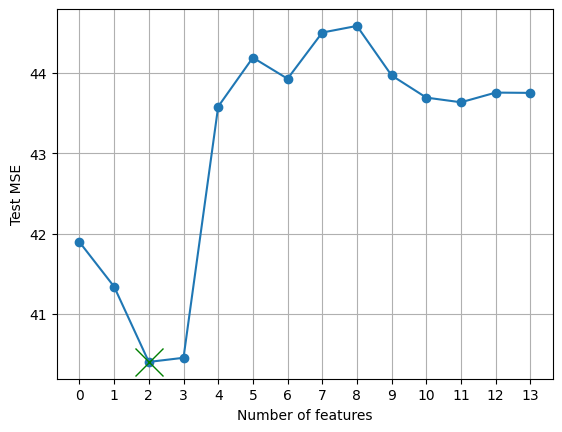

In [ ]:
plt.plot(test_MSEs, marker='o')
plt.xlabel('Number of features')
plt.ylabel('Test MSE')
plt.xticks(np.arange(0, X_train.shape[1], 1))

plt.plot(np.argmin(test_MSEs), np.min(test_MSEs), 'gx', markersize=20)
plt.grid()

In [ ]:
bestsub_boston2.model[2].params

const    20.220030
rad       0.412905
medv     -1.529519
medv2     0.023629
dtype: float64

In [ ]:
test_MSEs[2]

40.40265936487221

### 11.c

#### Proposed model does not involve all of the features in the data.